Part 1:

In [3]:
# Import necessary libraries
import torch                  # PyTorch library for building and training neural networks
import torch.nn as nn         # Neural network module
import torch.optim as optim   # Optimization algorithms
import numpy as np            # Numerical operations
import matplotlib.pyplot as plt  # Visualization
from torch.utils.data import DataLoader, TensorDataset  # Data handling utilities



In [4]:
# ------------------ Dataset Preparation ------------------

# Generate a circular dataset (synthetic data points on a circle)
theta = np.linspace(0, 2 * np.pi, 100)  # Angles from 0 to 2π
radius = 3                              # Fixed radius for the circle
x_circle = radius * np.cos(theta)       # x-coordinates of the circle
y_circle = radius * np.sin(theta)       # y-coordinates of the circle
data = np.stack((x_circle, y_circle), axis=1)  # Combine x and y into 2D points

# Convert data to PyTorch tensors (for use in the model)
data = torch.tensor(data, dtype=torch.float32)

# Create a DataLoader to iterate over the data in batches
batch_size = 10  # Number of samples per batch
dataset_loader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)



In [5]:
# ------------------ VAE Model Definition ------------------

# Define the Variational Autoencoder (VAE) class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder: Maps input data to a latent representation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),  # First layer with 32 neurons
            nn.ReLU(),                 # Activation function
            nn.Linear(32, 16),         # Second layer with 16 neurons
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)      # Outputs the mean (μ) of the latent space
        self.fc_logvar = nn.Linear(16, latent_dim)  # Outputs the log-variance (log σ^2) of the latent space

        # Decoder: Maps the latent representation back to the input space
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),  # First layer in decoder
            nn.ReLU(),
            nn.Linear(16, 32),          # Second layer
            nn.ReLU(),
            nn.Linear(32, input_dim)    # Final layer to match input dimensions
        )

    # Encode function: Projects input to latent space parameters (μ, log σ^2)
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)             # Mean of the latent space
        logvar = self.fc_logvar(h)     # Log-variance of the latent space
        return mu, logvar

    # Reparameterization trick: Samples latent variables z from N(μ, σ^2)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation from log-variance
        eps = torch.randn_like(std)    # Random noise sampled from a standard normal distribution
        return mu + eps * std          # Latent variable z = μ + σ * ε

    # Decode function: Maps latent variable z back to input space
    def decode(self, z):
        return self.decoder(z)

    # Forward pass: Combines encoding, reparameterization, and decoding
    def forward(self, x):
        mu, logvar = self.encode(x)       # Encode input
        z = self.reparameterize(mu, logvar)  # Sample z using reparameterization trick
        return self.decode(z), mu, logvar  # Return reconstructed input, μ, and log σ^2



In [6]:
# ------------------ Loss Function ------------------

# Define the VAE loss function
def vae_loss(recon_x, x, mu, logvar, recon_weight=10):
    # Reconstruction loss: Measures how well the reconstructed data matches the original
    recon_loss = recon_weight * nn.MSELoss()(recon_x, x)

    # KL divergence: Regularizes the latent space to follow a standard normal distribution
    kl_div = -0.05 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div / x.size(0)  # Normalize KL divergence by batch size



In [7]:
# ------------------ Model Initialization ------------------

# Define model parameters
input_dim = 2  # Dimensionality of the input (x, y coordinates)
latent_dim = 2  # Latent space dimension (allows 2D representation of the data)

# Initialize the VAE model and optimizer
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001



In [8]:
# ------------------ Training the VAE ------------------

# Define training parameters
num_epochs = 1000  # Number of epochs for training
for epoch in range(num_epochs):
    vae.train()  # Set model to training mode
    total_loss = 0

    for batch in dataset_loader:
        batch_data = batch[0]           # Extract batch data
        optimizer.zero_grad()           # Clear gradients from the previous step

        # Forward pass through the VAE
        recon_data, mu, logvar = vae(batch_data)

        # Compute the VAE loss
        loss = vae_loss(recon_data, batch_data, mu, logvar)

        # Backpropagate and update model parameters
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate loss for the epoch

    # Print average loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        avg_loss = total_loss / len(dataset_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')



Epoch [100/1000], Loss: 0.8002
Epoch [200/1000], Loss: 0.7296
Epoch [300/1000], Loss: 0.7088
Epoch [400/1000], Loss: 0.7117
Epoch [500/1000], Loss: 0.7242
Epoch [600/1000], Loss: 0.7210
Epoch [700/1000], Loss: 0.7103
Epoch [800/1000], Loss: 0.6901
Epoch [900/1000], Loss: 0.6882
Epoch [1000/1000], Loss: 0.7185


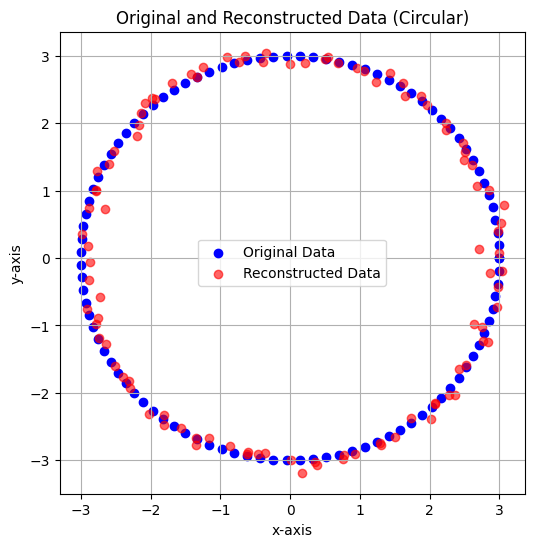

In [10]:
# ------------------ Evaluation and Visualization ------------------

# Set the model to evaluation mode
vae.eval()
reconstructed_data = []

# Generate reconstructed data from the model
with torch.no_grad():
    for batch in dataset_loader:
        batch_data = batch[0]
        recon_batch, _, _ = vae(batch_data)
        reconstructed_data.append(recon_batch)

# Convert reconstructed data to numpy format for visualization
reconstructed_data = torch.cat(reconstructed_data).numpy()
data_np = data.numpy()

# Plot original data and reconstructed data
plt.figure(figsize=(6, 6))
plt.scatter(data_np[:, 0], data_np[:, 1], color='blue', label='Original Data')  # Original circular data
plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], color='red', alpha=0.6, label='Reconstructed Data')  # Reconstructed data
plt.legend()
plt.title("Original and Reconstructed Data (Circular)")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid(True)
plt.show()


Part 2:

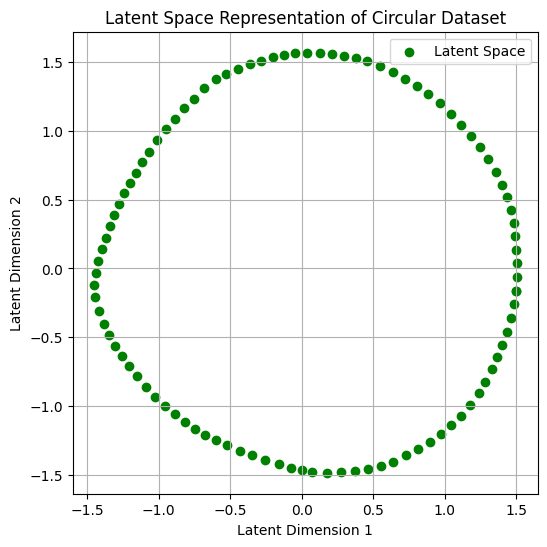

In [12]:
# To plot the latent space of the trained VAE by extracting the `mu` (mean) values for each input point, you can modify the code as follows:

# ------------------ Latent Space Visualization ------------------

# Set the model to evaluation mode
vae.eval()
latent_space = []

# Extract the latent space (mu values) for each input point
with torch.no_grad():
    for batch in dataset_loader:
        batch_data = batch[0]
        mu, _ = vae.encode(batch_data)
        latent_space.append(mu)

# Convert latent space data to numpy format for visualization
latent_space = torch.cat(latent_space).numpy()

# Plot the latent space
plt.figure(figsize=(6, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], color='green', label='Latent Space')
plt.legend()
plt.title("Latent Space Representation of Circular Dataset")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()


Part 3:

Epoch [100/1000], Loss: 1.2961
Epoch [200/1000], Loss: 1.1519
Epoch [300/1000], Loss: 1.0709
Epoch [400/1000], Loss: 1.0176
Epoch [500/1000], Loss: 0.9981
Epoch [600/1000], Loss: 1.0884
Epoch [700/1000], Loss: 0.9332
Epoch [800/1000], Loss: 1.0384
Epoch [900/1000], Loss: 0.9453
Epoch [1000/1000], Loss: 0.9344


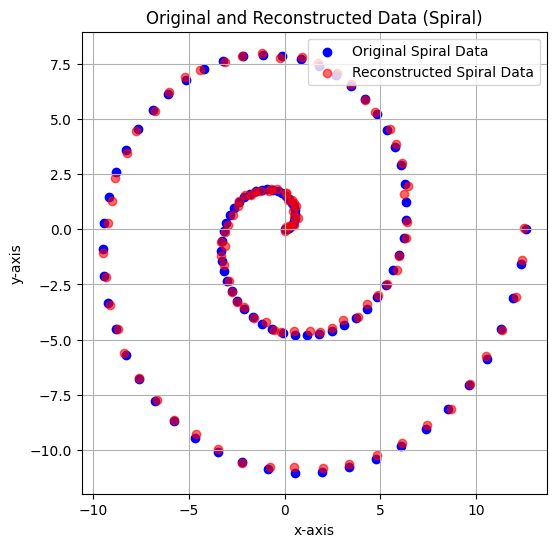

In [14]:
# ------------------ New Synthetic Data Preparation (Spiral) ------------------

# Generate a spiral dataset
theta_spiral = np.linspace(0, 4 * np.pi, 100)  # Angles from 0 to 4π
r_spiral = theta_spiral  # Radius increases with angle
x_spiral = r_spiral * np.cos(theta_spiral)  # x-coordinates of the spiral
y_spiral = r_spiral * np.sin(theta_spiral)  # y-coordinates of the spiral
data_spiral = np.stack((x_spiral, y_spiral), axis=1)  # Combine x and y into 2D points

# Convert data to PyTorch tensors (for use in the model)
data_spiral = torch.tensor(data_spiral, dtype=torch.float32)

# Create a DataLoader to iterate over the data in batches
dataset_loader_spiral = DataLoader(TensorDataset(data_spiral), batch_size=batch_size, shuffle=True)

# ------------------ Training the VAE on Spiral Data ------------------

# Define training parameters
num_epochs_spiral = 1000  # Number of epochs for training
for epoch in range(num_epochs_spiral):
    vae.train()  # Set model to training mode
    total_loss_spiral = 0

    for batch in dataset_loader_spiral:
        batch_data = batch[0]           # Extract batch data
        optimizer.zero_grad()           # Clear gradients from the previous step

        # Forward pass through the VAE
        recon_data, mu, logvar = vae(batch_data)

        # Compute the VAE loss
        loss = vae_loss(recon_data, batch_data, mu, logvar)

        # Backpropagate and update model parameters
        loss.backward()
        optimizer.step()

        total_loss_spiral += loss.item()  # Accumulate loss for the epoch

    # Print average loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        avg_loss_spiral = total_loss_spiral / len(dataset_loader_spiral)
        print(f'Epoch [{epoch+1}/{num_epochs_spiral}], Loss: {avg_loss_spiral:.4f}')

# ------------------ Evaluation and Visualization of Spiral Data ------------------

# Set the model to evaluation mode
vae.eval()
reconstructed_data_spiral = []

# Generate reconstructed data from the model
with torch.no_grad():
    for batch in dataset_loader_spiral:
        batch_data = batch[0]
        recon_batch, _, _ = vae(batch_data)
        reconstructed_data_spiral.append(recon_batch)

# Convert reconstructed data to numpy format for visualization
reconstructed_data_spiral = torch.cat(reconstructed_data_spiral).numpy()
data_spiral_np = data_spiral.numpy()

# Plot original data and reconstructed data
plt.figure(figsize=(6, 6))
plt.scatter(data_spiral_np[:, 0], data_spiral_np[:, 1], color='blue', label='Original Spiral Data')  # Original spiral data
plt.scatter(reconstructed_data_spiral[:, 0], reconstructed_data_spiral[:, 1], color='red', alpha=0.6, label='Reconstructed Spiral Data')  # Reconstructed data
plt.legend()
plt.title("Original and Reconstructed Data (Spiral)")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid(True)
plt.show()